# Performance Evaluation of Terapixel rendering in Cloud (Super)computing 

## Background
Similar to other projects which use high resources and intensive calculation (in this case rendering very large image), the large scale project of Terapixel 3D city visualisation needs to be evaluated.
This project is an evaluation project to inverstigate on how the rendering task is managed by the Cloud Supercomputing based on resources utilisation. The expected output of this project is complete analysis of the performance differences between the GPUs. There are 1024 unique GPUs which the rendering tasks are dispatched. 

## Methods
### Project Management
This project will refer to normal data science project although not all steps will be done.
### Tools
There will be several tools and technology that are used in this project. Programming language use Python and using Jupyter Notebook as literate programming tools. Next, MongoDB is used for persistent database and Docker as virtualisation tools and contained for the MongoDB database.
#### persistent database vs cache/csv

### Evaluation Methods
This project implements the 12 rules from Scientific Benchmarking of Parallel Computing Systems (Hoefler and Belli, 2015).

performance should compare between duration and the utilization of the hardware. if it is utilize to the fullest (i.e. more than 80% utilization) and also duration is short.

it can be started by find the shortest duration and then continue to compare it with the longer duration to see if there is some decreasing utilization of the software. On the other hand make sure it is on the same level of difficulty which in this case might be related to level (4 or 8 or 12) or related to tile position (x and y)

it will be good if task type can be shown in scatter plot.Compare between average gpu utilization and  

check how many task that completed for each GPU

in terms of GPU activity, the tasks distributed normally with distribution range between 1450 and 1500. On the other hand in terms of the task dispatching each GPU/hostname can be seen on table below:

## References
Hoefler, T. and Belli, R. (2015). Scientific benchmarking of parallel computing systems. Proceedings of the International Conference for High Performance Computing, Networking, Storage and Analysis on - SC '15.

In [1]:
from pymongo import MongoClient
import pandas as pd
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## connect to Database
client = MongoClient()
client = MongoClient('localhost', 3306)
db = client.csv_merge

In [3]:
taskset = db.taskIds
db_application_checkpoints = db.apps
db_task_XY = db.taskXY
db_gpu = db.gpu

df = pd.DataFrame(list(taskset.find()))
df.columns

Index(['_id', 'duration', 'eventName', 'startTime', 'stopTime', 'taskid'], dtype='object')

In [4]:
db_application_checkpoints = db.apps
db_task_XY = db.taskXY
db_gpu = db.gpu
db_gpu_master = db.gpu_master
db_task_ids = db.taskids_host
db_task_gpu_tile = db.task_gpu_tile
df_application_checkpoints = pd.DataFrame(list(db_application_checkpoints.find().limit(3)))
df_gpu = pd.DataFrame(list(db_gpu.find().limit(3)))
df_task_XY = pd.DataFrame(list(db_task_XY.find().limit(3)))
df_gpu_master = pd.DataFrame(list(db_gpu_master.find().limit(3)))
df_task_ids = pd.DataFrame(list(db_task_ids.find().limit(3)))
df_task_gpu_tile = pd.DataFrame(list(db_task_gpu_tile.find().limit(3)))

## Implementation
Using some subset from CRISP-DM framework, the implementation phase includes Data Understanding and Data Preparation.

### Data Understanding
There are three raw datasets and 3 additionals that are used for this project. These six datasets stored in MongoDB persistend database for easy and efficient access. 

### Data preparation
There are three raw datasets and 3 additionals that are used for this project. These six datasets stored in MongoDB persistend database for easy and efficient access. 

#### Application checkpoints

In [1]:
df_application_checkpoints.iloc[:,[1,2,3,4,5,6]]

NameError: name 'df_application_checkpoints' is not defined

#### GPU Utilisation

In [21]:
df_gpu.iloc[:,[1,2,3,4,5,6,7,8]]

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,hostname,powerDrawWatt,timestamp
0,53,323217055910,48,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,92,8b6a0eebc87b4cb2b0539e81075191b900001C,131.55,2018-11-08T08:27:10.314Z
1,48,323617020295,40,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,92,d8241877cd994572b46c861e5d144c85000000,117.03,2018-11-08T08:27:10.192Z
2,44,323217056562,45,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,91,db871cd77a544e13bc791a64a0c8ed50000006,121.64,2018-11-08T08:27:10.842Z


#### Mapping between image tile and the rendering task

In [22]:
df_task_XY.iloc[:,[1,2,3,4,5]]

,jobId,level,taskId,x,y
0,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,00004e77-304c-4fbd-88a1-1346ef947567,116,178
1,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,142,190
2,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,0003c380-4db9-49fb-8e1c-6f8ae466ad85,142,86


Based on these three datasets, generated several other datasets to help with explaratory data analysis later. These additional datasets were created using merge, join and group by.

#### GPU Master
Dataset that contains all 1024 unique GPU and hostname information including the serial number and unique-id.

In [26]:
df_gpu_master.iloc[:,[1,2,3,4]]

,gpuSerial,gpuUUID,hostname,hostnumber
0,320118118607,GPU-c926aca5-c234-0d79-0778-d4672fedc0d6,5903af3699134795af7eafc605ae5fc700000E,1
1,320118118641,GPU-ce6cb6dd-5be7-934b-ff1b-c156725497ba,95b4ae6d890e4c46986d91d7ac4bf082000005,2
2,320118118702,GPU-317830c7-3b7b-0770-0d88-85585d11fce4,95b4ae6d890e4c46986d91d7ac4bf08200000Y,3



#### Task Detail 
Task detail dataset is basically similar to "application checkpoints" dataset but instead of store the "start time" and "stop time" in different records it store it in one record and by put them in one record the duration can be calculated. In this dataset each task will have 5 records that representing the event name (i.e. Render, Tiling, Uploading, Total Render and Saving Config). The new column (duration) store the difference between stopTime- startTime and it's unit measure in milliseconds(1/1000 second).

In [33]:
df_task_ids.iloc[:,[1,2,3,4,5,6,7]]

,duration,eventName,hostname,jobId,startTime,stopTime,taskid
0,1013.0,Tiling,95b4ae6d890e4c46986d91d7ac4bf08200000U,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08 08:03:28.214000,2018-11-08 08:03:29.227000,fe81b1e2-7466-4e13-8392-e3a3434421ad
1,48174.0,TotalRender,95b4ae6d890e4c46986d91d7ac4bf08200000U,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08 08:02:41.210000,2018-11-08 08:03:29.384000,fe81b1e2-7466-4e13-8392-e3a3434421ad
2,2.0,Saving Config,95b4ae6d890e4c46986d91d7ac4bf08200000U,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08 08:02:41.210000,2018-11-08 08:02:41.212000,fe81b1e2-7466-4e13-8392-e3a3434421ad


Based on these three datasets, generated several other datasets to help with explaratory data analysis later. These additional datasets were created using merge, join and group by.

#### Task GPU and Tile dataset
This dataset combines the three original dataset into one table for ease of access.

In [35]:
df_task_gpu_tile.iloc[:,[1,2,3,4,5,6,7]]

,gpu,hostname,jobid,start,stop,taskid,tilexy
0,"[{'gpuSerial': 325017017635, 'gpuUUID': 'GPU-3...",b9a1fa7ae2f74eb68f25f607980f97d700000K,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08T08:02:28.268Z,2018-11-08T08:03:18.691Z,e97027d1-e243-4c43-aa83-7489b85e00b4,"{'x': 14, 'y': 83, 'level': 12}"
1,"[{'gpuSerial': 323617020988, 'gpuUUID': 'GPU-5...",db871cd77a544e13bc791a64a0c8ed50000009,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08T08:28:07.856Z,2018-11-08T08:28:50.437Z,9e26a62e-4b49-40b5-ba43-e0dec6191f9b,"{'x': 176, 'y': 203, 'level': 12}"
2,"[{'gpuSerial': 323617042980, 'gpuUUID': 'GPU-a...",2ecb9d8d51bc457aac88073f6da05461000015,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08T08:02:15.540Z,2018-11-08T08:02:47.559Z,16b39d16-8ae9-4dfc-9eaf-2b3560ecb626,"{'x': 120, 'y': 193, 'level': 12}"


In [37]:
dataframe3 = pd.merge(df[df['eventName'] != 'TotalRender'], df[df['eventName'] == 'TotalRender'], on='taskid', how='left')

In [38]:
dataframe3 = dataframe3.iloc[:, [1, 2, 5, 7]]

In [40]:
def percentage_func(row):
    return (row['duration_x'] / row['duration_y']) * 100

dataframe3['percentage'] = dataframe3.apply(percentage_func, axis=1)


## Exploratory Data Analysis Result
This part contains the Exploratory Data Analaysis that is done to fulfill the objective.

### Event Duration per Task
To get a good insight about processes that run in a task, analyse the correlation between task and event.

Table below shows one task and all events in it. Each task actually contains of five events (Total Render, Saving Config, Render, Tiling and Uploading), but because it is actually the sum of the other four event hence "Total Render" event is not included in the table.

In [43]:
dataframe3[dataframe3['taskid'] == 'fe81b1e2-7466-4e13-8392-e3a3434421ad']

,duration_x,eventName_x,taskid,duration_y,percentage
0,1013.0,Tiling,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,2.102794
1,2.0,Saving Config,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,0.004152
2,46995.0,Render,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,97.552622
3,1177.0,Uploading,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,2.443227




Bar graph below shows that event "Render" dominates the runtimes of the task. From the total 48 second, it takes 46 (more than 97%) seconds to finish the Render.

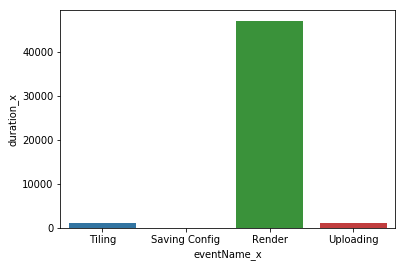

In [45]:
sns.barplot(x = 'eventName_x', y='duration_x', data=dataframe3[dataframe3['taskid'] == 'fe81b1e2-7466-4e13-8392-e3a3434421ad'])

The comparison for all the tasks it shows using box plot below for better comparisons. The box plot shows that the majority percentages of the Render more than 95% although there are some outliers that fall below 40%. For Uploading event the majority percentages below 10% but the outliers can increase until more than 40%.

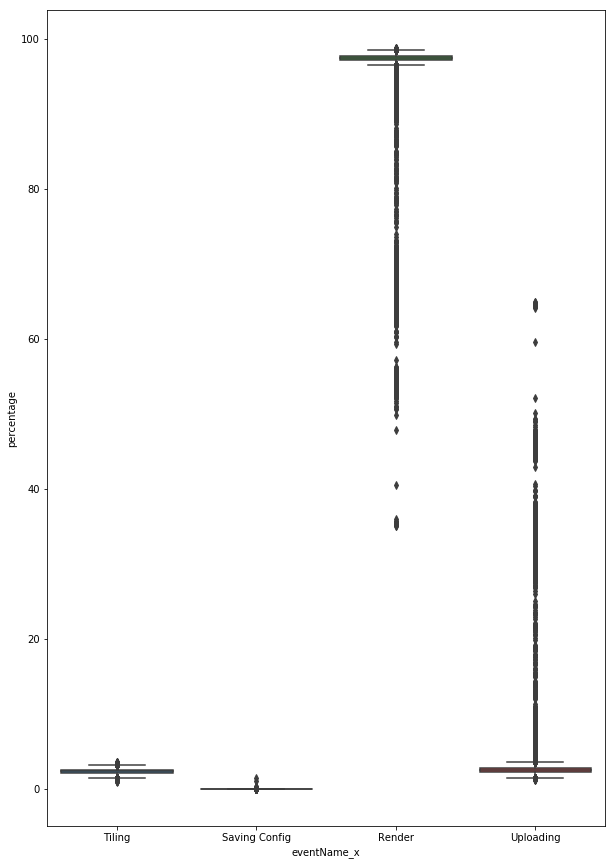

In [46]:
a4_dims = (10, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(ax = ax, x="eventName_x", y="percentage", data=dataframe3)



### Interplay between variables in GPU

In [5]:
df_gpu = pd.DataFrame(list(db_gpu.find()))

In [6]:
df_gpu.columns

Index(['_id', 'gpuMemUtilPerc', 'gpuSerial', 'gpuTempC', 'gpuUUID',
       'gpuUtilPerc', 'hostname', 'powerDrawWatt', 'timestamp'],
      dtype='object')

In [7]:
df_gpu_cut = df_gpu.iloc[:, [1,3,5,7]]
df_gpu_cut.head()

,gpuMemUtilPerc,gpuTempC,gpuUtilPerc,powerDrawWatt
0,53,48,92,131.55
1,48,40,92,117.03
2,44,45,91,121.64
3,43,38,90,50.23
4,47,41,90,141.82


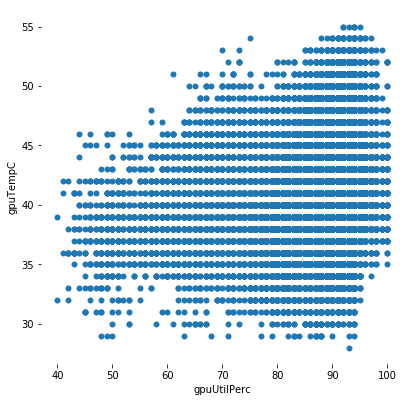

In [8]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="gpuUtilPerc", y="gpuTempC", palette="ch:r=-.2,d=.3_r", linewidth=0, data=df_gpu_cut[df_gpu_cut['gpuMemUtilPerc']>30], ax=ax)

,gpuMemUtilPerc,gpuTempC,gpuUtilPerc,powerDrawWatt
gpuMemUtilPerc,1.000000,0.492783,0.966571,0.870745
gpuTempC,0.492783,1.000000,0.505906,0.537191
gpuUtilPerc,0.966571,0.505906,1.000000,0.862673
powerDrawWatt,0.870745,0.537191,0.862673,1.000000


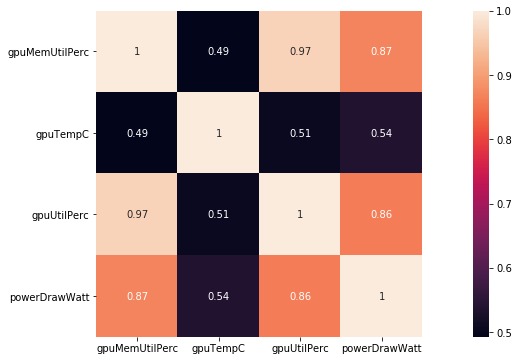

In [10]:
a4_dims = (18, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(df_gpu_cut.corr(), vmax=1, square=True, annot=True)
df_gpu_cut.corr()

In [4]:
task_gpu_tile_set = db.task_gpu_tile
df_task_gpu_tile = pd.DataFrame(list(task_gpu_tile_set.find({'taskid': 'e97027d1-e243-4c43-aa83-7489b85e00b4'})))

In [5]:
print(df_task_gpu_tile.columns)
print(len(df_task_gpu_tile))

Index(['_id', 'gpu', 'hostname', 'jobid', 'start', 'stop', 'taskid', 'tilexy'], dtype='object')
1


In [6]:
print(df_task_gpu_tile['gpu'])

0    [{'gpuSerial': 325017017635, 'gpuUUID': 'GPU-3...
Name: gpu, dtype: object


In [7]:
gpu_per_task = pd.DataFrame(list(df_task_gpu_tile['gpu']))

In [8]:
json1 = json.loads(gpu_per_task.to_json(orient='records'))[0]

In [9]:
test_gpu_df = pd.DataFrame(json1)
test_gpu_df = test_gpu_df.T

print (type(test_gpu_df.timestamp))

#print(datetime.strptime(test_gpu_df['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ'))

#test_gpu_df['timestamp'] = datetime.strptime(app['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')
#pd.to_datetime('13000101', format='%Y%m%d', errors='ignore')

<class 'pandas.core.series.Series'>


In [10]:
test_gpu_df['timestamp'] = test_gpu_df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

In [11]:
test_gpu_df['powerDrawWatt'] = pd.to_numeric(test_gpu_df['powerDrawWatt'])

In [12]:
test_gpu_df.sort_values(by=['timestamp'])

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,powerDrawWatt,timestamp
2,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,27.08,2018-11-08 08:02:28.585
8,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,26.22,2018-11-08 08:02:30.602
10,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,42.19,2018-11-08 08:02:32.618
13,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,42.18,2018-11-08 08:02:34.635
18,61,325017017635,42,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,88,135.04,2018-11-08 08:02:36.652
12,57,325017017635,42,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,92,102.63,2018-11-08 08:02:38.668
23,58,325017017635,42,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,93,90.77,2018-11-08 08:02:40.685
11,59,325017017635,43,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,94,144.70,2018-11-08 08:02:42.701
24,46,325017017635,43,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,91,131.58,2018-11-08 08:02:44.718
21,58,325017017635,43,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,93,138.39,2018-11-08 08:02:46.734


In [16]:
df_task_time = df.iloc[:, [2, 3, 4, 1, 5]]
df_task_time.sort_values(by=['startTime'])

,eventName,startTime,stopTime,duration,taskid
198667,Saving Config,2018-11-08 07:41:30.957000,2018-11-08 07:41:30.960000,3.0,844c4341-0884-4ca9-9518-e0f2893f0252
198666,TotalRender,2018-11-08 07:41:30.957000,2018-11-08 07:42:30.106000,59149.0,844c4341-0884-4ca9-9518-e0f2893f0252
198668,Render,2018-11-08 07:41:30.960000,2018-11-08 07:42:09.994000,39034.0,844c4341-0884-4ca9-9518-e0f2893f0252
84521,TotalRender,2018-11-08 07:41:30.962000,2018-11-08 07:42:30.530000,59568.0,f0b66da0-3eb5-48cc-b6d2-5ae12377b849
84522,Saving Config,2018-11-08 07:41:30.963000,2018-11-08 07:41:30.965000,2.0,f0b66da0-3eb5-48cc-b6d2-5ae12377b849
84523,Render,2018-11-08 07:41:30.965000,2018-11-08 07:42:09.777000,38812.0,f0b66da0-3eb5-48cc-b6d2-5ae12377b849
281272,Saving Config,2018-11-08 07:41:30.968000,2018-11-08 07:41:30.970000,2.0,10a05c55-cd7a-4319-aba1-ae0c706853f4
281271,TotalRender,2018-11-08 07:41:30.968000,2018-11-08 07:42:32.144000,61176.0,10a05c55-cd7a-4319-aba1-ae0c706853f4
236922,Saving Config,2018-11-08 07:41:30.969000,2018-11-08 07:41:30.972000,3.0,dbe5f8c6-fdb8-4866-bc6b-37a438fc5f41
236921,TotalRender,2018-11-08 07:41:30.969000,2018-11-08 07:42:39.939000,68970.0,dbe5f8c6-fdb8-4866-bc6b-37a438fc5f41


In [17]:
test_gpu_df_plot1 = test_gpu_df.sort_values(by=['timestamp'])
test_gpu_df_plot1 = test_gpu_df_plot1.reset_index(drop=True)
test_gpu_df_plot1['stepNumber'] = test_gpu_df_plot1.index + 1000


test_gpu_df_plot1

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,powerDrawWatt,timestamp,stepNumber
0,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,27.08,2018-11-08 08:02:28.585,1000
1,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,26.22,2018-11-08 08:02:30.602,1001
2,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,42.19,2018-11-08 08:02:32.618,1002
3,0,325017017635,39,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,0,42.18,2018-11-08 08:02:34.635,1003
4,61,325017017635,42,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,88,135.04,2018-11-08 08:02:36.652,1004
5,57,325017017635,42,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,92,102.63,2018-11-08 08:02:38.668,1005
6,58,325017017635,42,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,93,90.77,2018-11-08 08:02:40.685,1006
7,59,325017017635,43,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,94,144.70,2018-11-08 08:02:42.701,1007
8,46,325017017635,43,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,91,131.58,2018-11-08 08:02:44.718,1008
9,58,325017017635,43,GPU-3d886815-1c7c-ad88-a8a2-5fed4cadf015,93,138.39,2018-11-08 08:02:46.734,1009


In [18]:
print(test_gpu_df_plot1.dtypes)

gpuMemUtilPerc            object
gpuSerial                 object
gpuTempC                  object
gpuUUID                   object
gpuUtilPerc               object
powerDrawWatt            float64
timestamp         datetime64[ns]
stepNumber                 int64
dtype: object


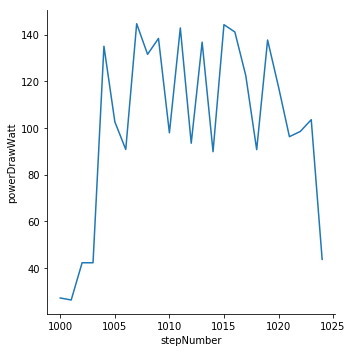

In [21]:
sns.relplot(x='stepNumber', y="powerDrawWatt", kind='line', data=test_gpu_df_plot1)

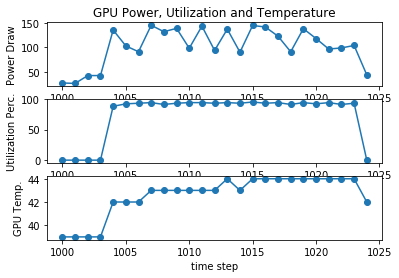

In [55]:
#ax = sns.lineplot(x="stepNumber", y="powerDrawWatt", data=test_gpu_df_plot1)

plt.subplot(3, 1, 1)
plt.plot(test_gpu_df_plot1['stepNumber'], test_gpu_df_plot1['powerDrawWatt'], 'o-')
plt.title('GPU Power, Utilization and Temperature')
plt.ylabel('Power Draw')

plt.subplot(3, 1, 2)
plt.plot(test_gpu_df_plot1['stepNumber'], test_gpu_df_plot1['gpuUtilPerc'], 'o-')
plt.ylabel('Utilization Perc.')

plt.subplot(3, 1, 3)
plt.plot(test_gpu_df_plot1['stepNumber'], test_gpu_df_plot1['gpuTempC'], 'o-')
plt.xlabel('time step')
plt.ylabel('GPU Temp.')

plt.show()

In [47]:
tilelevel_per_task = pd.DataFrame(list(df_task_gpu_tile['tilexy']))
tilelevel_per_task

,level,x,y
0,12,14,83


In [66]:
taskXYset = db.taskXY
taskXYset_level8 = pd.DataFrame(list(taskXYset.find({'level': 8})))
#taskXYset_level8['taskId']

In [68]:
taskidset2 = pd.DataFrame(list(taskset.find({'eventName': 'Render', 'taskid': { '$in': list(taskXYset_level8['taskId']) }})))
taskidset2 = taskidset2.sort_values(by=['duration'])
taskidset2 = taskidset2.reset_index(drop=True)
taskidset2['stepNumber'] = taskidset2.index + 1000
taskidset2

,_id,duration,eventName,startTime,stopTime,taskid,stepNumber
0,5c3e79da7653792483ef482e,22880.0,Render,2018-11-08 07:41:50.165000,2018-11-08 07:42:13.045000,fb9f46a2-a940-4773-996f-6db2204350d2,1000
1,5c3e89ce7653792483f0bf33,23255.0,Render,2018-11-08 07:41:50.750000,2018-11-08 07:42:14.005000,638044d9-16a0-4ee7-a5e0-b594883fc85c,1001
2,5c3e85817653792483f059e4,23405.0,Render,2018-11-08 07:42:15.954000,2018-11-08 07:42:39.359000,58ed7e09-f8d5-4745-a11d-148299bc2e9d,1002
3,5c3eaaaf7653792483f3c67e,23510.0,Render,2018-11-08 07:42:15.033000,2018-11-08 07:42:38.543000,3db75c4b-e0be-4a77-a1a0-b8077be2e5e7,1003
4,5c3e91a47653792483f1784c,23521.0,Render,2018-11-08 07:42:09.909000,2018-11-08 07:42:33.430000,5d1e1704-46cb-44c3-bbeb-1fc13f238317,1004
5,5c3e8f1a7653792483f13c60,24486.0,Render,2018-11-08 07:41:50.161000,2018-11-08 07:42:14.647000,38ea5505-6869-4ded-9b08-e47714015f0a,1005
6,5c3e85be7653792483f05f75,26202.0,Render,2018-11-08 07:42:32.856000,2018-11-08 07:42:59.058000,c21a045f-acb5-4ec3-b834-fc8ed4e63ccd,1006
7,5c3e7d307653792483ef96da,28891.0,Render,2018-11-08 07:42:27.828000,2018-11-08 07:42:56.719000,ff1758b0-0a39-4f72-be8e-8ead79d691a6,1007
8,5c3ea1e87653792483f2f84d,29346.0,Render,2018-11-08 07:42:31.816000,2018-11-08 07:43:01.162000,04cf0a46-41b7-4970-bd4f-84968b151ed4,1008
9,5c3e88487653792483f09b3e,29783.0,Render,2018-11-08 07:42:12.647000,2018-11-08 07:42:42.430000,2b0c31b3-df35-4b7e-9130-499e2e963969,1009


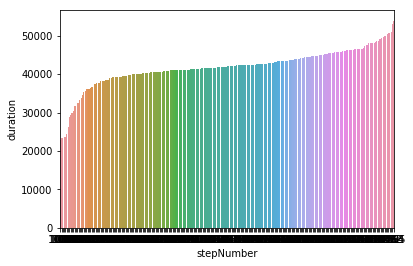

In [70]:
sns.barplot(x = 'stepNumber', y='duration', data=taskidset2)

lowest = fb9f46a2-a940-4773-996f-6db2204350d2
highest = 5e0c7e56-dd20-413f-ad75-feda4ccf17b2	

In [87]:
lowest_task_duratin_df = pd.DataFrame(list(task_gpu_tile_set.find({'taskid': 'fb9f46a2-a940-4773-996f-6db2204350d2'})))
gpu_lowest_duration_df = pd.DataFrame(list(lowest_task_duratin_df['gpu']))
json3 = json.loads(gpu_lowest_duration_df.to_json(orient='records'))[0]
gpu_lowest_duration_df = pd.DataFrame(json3)
gpu_lowest_duration_df = gpu_lowest_duration_df.T
gpu_lowest_duration_df = gpu_lowest_duration_df.sort_values(by=['timestamp'])
gpu_lowest_duration_df = gpu_lowest_duration_df.reset_index(drop=True)
gpu_lowest_duration_df['stepNumber'] = gpu_lowest_duration_df.index + 1000

highest_task_duratin_df = pd.DataFrame(list(task_gpu_tile_set.find({'taskid': '8678ac52-d86e-4789-a799-9e8970015ede'})))
gpu_highest_duration = pd.DataFrame(list(highest_task_duratin_df['gpu']))
json4 = json.loads(gpu_highest_duration.to_json(orient='records'))[0]
gpu_highest_duration = pd.DataFrame(json4)
gpu_highest_duration = gpu_highest_duration.T
gpu_highest_duration = gpu_highest_duration.sort_values(by=['timestamp'])
gpu_highest_duration = gpu_highest_duration.reset_index(drop=True)
gpu_highest_duration['stepNumber'] = gpu_highest_duration.index + 1000


In [88]:
gpu_lowest_duration_df

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,powerDrawWatt,timestamp,stepNumber
0,0,323617020145,30,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,0,25.25,2018-11-08T07:41:50.886Z,1000
1,0,323617020145,30,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,0,25.25,2018-11-08T07:41:52.905Z,1001
2,0,323617020145,30,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,0,34.96,2018-11-08T07:41:54.922Z,1002
3,21,323617020145,31,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,33,61.81,2018-11-08T07:41:56.938Z,1003
4,33,323617020145,32,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,81,69.69,2018-11-08T07:41:58.956Z,1004
5,32,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,79,79.02,2018-11-08T07:42:00.975Z,1005
6,33,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,83,82.39,2018-11-08T07:42:02.991Z,1006
7,33,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,84,70,2018-11-08T07:42:05.008Z,1007
8,33,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,83,86.05,2018-11-08T07:42:07.024Z,1008
9,34,323617020145,34,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,84,57.54,2018-11-08T07:42:09.042Z,1009


In [89]:
gpu_highest_duration

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,powerDrawWatt,timestamp,stepNumber
0,0,323217056367,32,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,0,25.56,2018-11-08T07:42:08.498Z,1000
1,0,323217056367,32,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,0,25.46,2018-11-08T07:42:10.519Z,1001
2,0,323217056367,33,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,0,40.97,2018-11-08T07:42:12.536Z,1002
3,13,323217056367,34,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,34,119.58,2018-11-08T07:42:14.552Z,1003
4,33,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,92,88.75,2018-11-08T07:42:16.569Z,1004
5,22,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,98,108.09,2018-11-08T07:42:18.591Z,1005
6,34,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,97,110.47,2018-11-08T07:42:20.608Z,1006
7,34,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,97,75.09,2018-11-08T07:42:22.625Z,1007
8,26,323217056367,37,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,92,96.92,2018-11-08T07:42:24.642Z,1008
9,45,323217056367,37,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,93,70.03,2018-11-08T07:42:26.659Z,1009


In [4]:
taskXYset = db.taskXY
#df = pd.DataFrame(list(taskset.find({'taskid': 'e97027d1-e243-4c43-aa83-7489b85e00b4'})))
df_taskXYset = pd.DataFrame(list(taskXYset.find()))
df_taskXYset.columns

Index(['_id', 'jobId', 'level', 'taskId', 'x', 'y'], dtype='object')

In [5]:
df_taskXY_l8_set = df_taskXYset[(df_taskXYset['level'] == 8)]
df_taskXY_l8_set.set_index('taskId')
len(df_taskXY_l8_set)

256

In [6]:
taskset_l8 = db.taskids_host
df_taskset_l8 = pd.DataFrame(list(taskset_l8.find({'eventName': 'TotalRender'})))

In [7]:
df_taskset_l8.columns
len(df_taskset_l8)

66040

In [8]:
df_duration_l8 = pd.merge(df_taskXY_l8_set, df_taskset_l8, left_on='taskId', right_on='taskid', how='left')
print(df_duration_l8.columns)

Index(['_id_x', 'jobId_x', 'level', 'taskId', 'x', 'y', '_id_y', 'duration',
       'eventName', 'hostname', 'jobId_y', 'startTime', 'stopTime', 'taskid'],
      dtype='object')


In [9]:
df_duration_l8 = df_duration_l8.iloc[:, [1,2,3,4,5,7,9]]
df_duration_l8['duration'] = df_duration_l8['duration']/1000


In [10]:
df_duration_l8.drop_duplicates(subset ="taskId", keep = 'first', inplace = True) 
len(df_duration_l8)

256

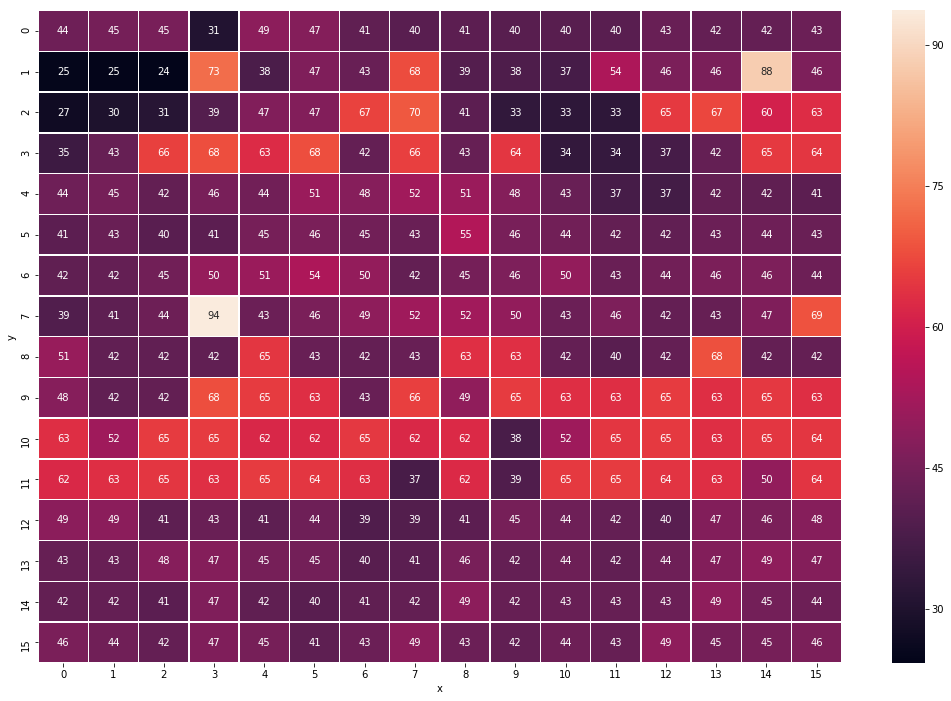

In [11]:
durations_l8 = df_duration_l8.pivot("y", "x", "duration")

f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(durations_l8, annot=True,  linewidths=.5, ax=ax)

In [23]:
db_gpu_master = db.gpu_master
df_gpu_master = pd.DataFrame(list(db_gpu_master.find()))

In [24]:
test = pd.merge(df_duration_l8, df_gpu_master, left_on='hostname', right_on='hostname', how='left')

In [25]:
test.head()

,jobId_x,level,taskId,x,y,duration,hostname,_id,gpuSerial,gpuUUID,hostnumber
0,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,00412c8d-7c0e-4017-bf28-b06dd118b683,14,4,41.537,cd44f5819eba427a816e7ce648adceb200000E,5c4545357653792f7ecda1e9,323617042890,GPU-938ef655-c524-d16d-6e28-67a434cc510c,535
1,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,024a45d1-04c4-4908-a03c-6c7c57ed1ac5,10,12,43.886,04dc4e9647154250beeee51b866b071500000M,5c4545357653792f7ecda086,323217056678,GPU-0a1cc8af-77e5-09ba-3a20-254f96cf9880,180
2,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,0363ce87-954c-4635-832a-49f5899f90f8,0,15,45.821,2ecb9d8d51bc457aac88073f6da0546100000Z,5c4545357653792f7ecda12f,323617020934,GPU-871d4230-76db-f266-8b92-3e35943e8dc7,349
3,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,03831d0b-4939-4de1-9717-164765b90266,4,2,46.903,6139a35676de44d6b61ec247f0ed865700001D,5c4545357653792f7ecd9fd8,320118118795,GPU-7662ee39-8822-2f95-9c68-18a9dc4feece,6
4,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,04cf0a46-41b7-4970-bd4f-84968b151ed4,3,1,72.533,4a79b6d2616049edbf06c6aa58ab426a00000V,5c4545357653792f7ecda272,325017017662,GPU-4ebdd000-216f-494b-18c3-8e399c7183b9,672


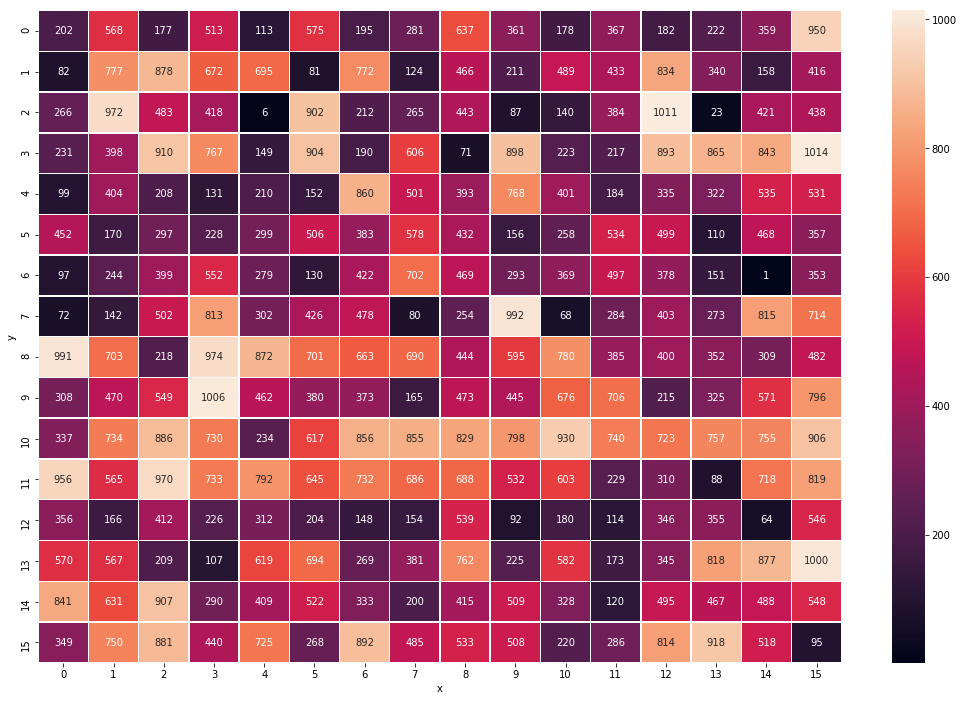

In [28]:
hostname_l8 = test.pivot("y", "x", "hostnumber")

f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(hostname_l8, annot=True,  fmt='d', linewidths=.5, ax=ax)

In [40]:
hostname_l8

x,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
y,,,,,,,,,,,,,,,,
0,202,568,177,513,113,575,195,281,637,361,178,367,182,222,359,950
1,82,777,878,672,695,81,772,124,466,211,489,433,834,340,158,416
2,266,972,483,418,6,902,212,265,443,87,140,384,1011,23,421,438
3,231,398,910,767,149,904,190,606,71,898,223,217,893,865,843,1014
4,99,404,208,131,210,152,860,501,393,768,401,184,335,322,535,531
5,452,170,297,228,299,506,383,578,432,156,258,534,499,110,468,357
6,97,244,399,552,279,130,422,702,469,293,369,497,378,151,1,353
7,72,142,502,813,302,426,478,80,254,992,68,284,403,273,815,714
8,991,703,218,974,872,701,663,690,444,595,780,385,400,352,309,482


In [37]:
db_gpu_summary = db.apps
df_gpu_summary = pd.DataFrame(list(db_gpu_summary.aggregate([
    {"$group" : {"_id":"$taskId", "count":{ "$sum":1}}}
])))

In [39]:
#df_gpu_summary
df_gpu_summary.sort_values(by=['count'])

,_id,count
0,93d8cfdd-2296-4f90-a436-83bc4ade2bd4,10
43805,1c867a8b-4b3e-41af-972b-0de537acf5df,10
43806,dad9b438-9695-429b-8781-52dd2a46302e,10
43807,0c4aab36-6015-4bab-ae41-37d54f07abb7,10
43808,03000ce8-14f9-4001-a1c2-c29ada66cef5,10
43809,db26ee66-de82-4bdb-a773-0283e4d39351,10
43810,5e616922-5543-49ec-95b0-3b67d9823a6a,10
43811,3d611009-6571-4725-b77c-1d31099e17fb,10
43812,95da60d9-b879-4e2f-a04b-982e20219584,10
43813,dad9e420-37d2-4264-b53b-3e91a442189c,10


level 12 tile

In [41]:
df_taskXY_l12_set = df_taskXYset[(df_taskXYset['level'] == 12)]
df_taskXY_l12_set.set_index('taskId')
len(df_taskXY_l12_set)

65536

In [42]:
taskset_l12 = db.taskids_host
df_taskset_l12 = pd.DataFrame(list(taskset_l8.find({'eventName': 'TotalRender'})))

In [45]:
df_taskset_l12.columns
len(df_taskset_l12)

66040

In [47]:
df_duration_l12 = pd.merge(df_taskXY_l12_set, df_taskset_l12, left_on='taskId', right_on='taskid', how='left')
print(df_duration_l12.columns)

Index(['_id_x', 'jobId_x', 'level', 'taskId', 'x', 'y', '_id_y', 'duration',
       'eventName', 'hostname', 'jobId_y', 'startTime', 'stopTime', 'taskid'],
      dtype='object')


In [48]:
df_duration_l12 = df_duration_l12.iloc[:, [1,2,3,4,5,7,9]]
df_duration_l12['duration'] = df_duration_l12['duration']/1000


In [49]:
df_duration_l12.drop_duplicates(subset ="taskId", keep = 'first', inplace = True) 
len(df_duration_l12)

65536

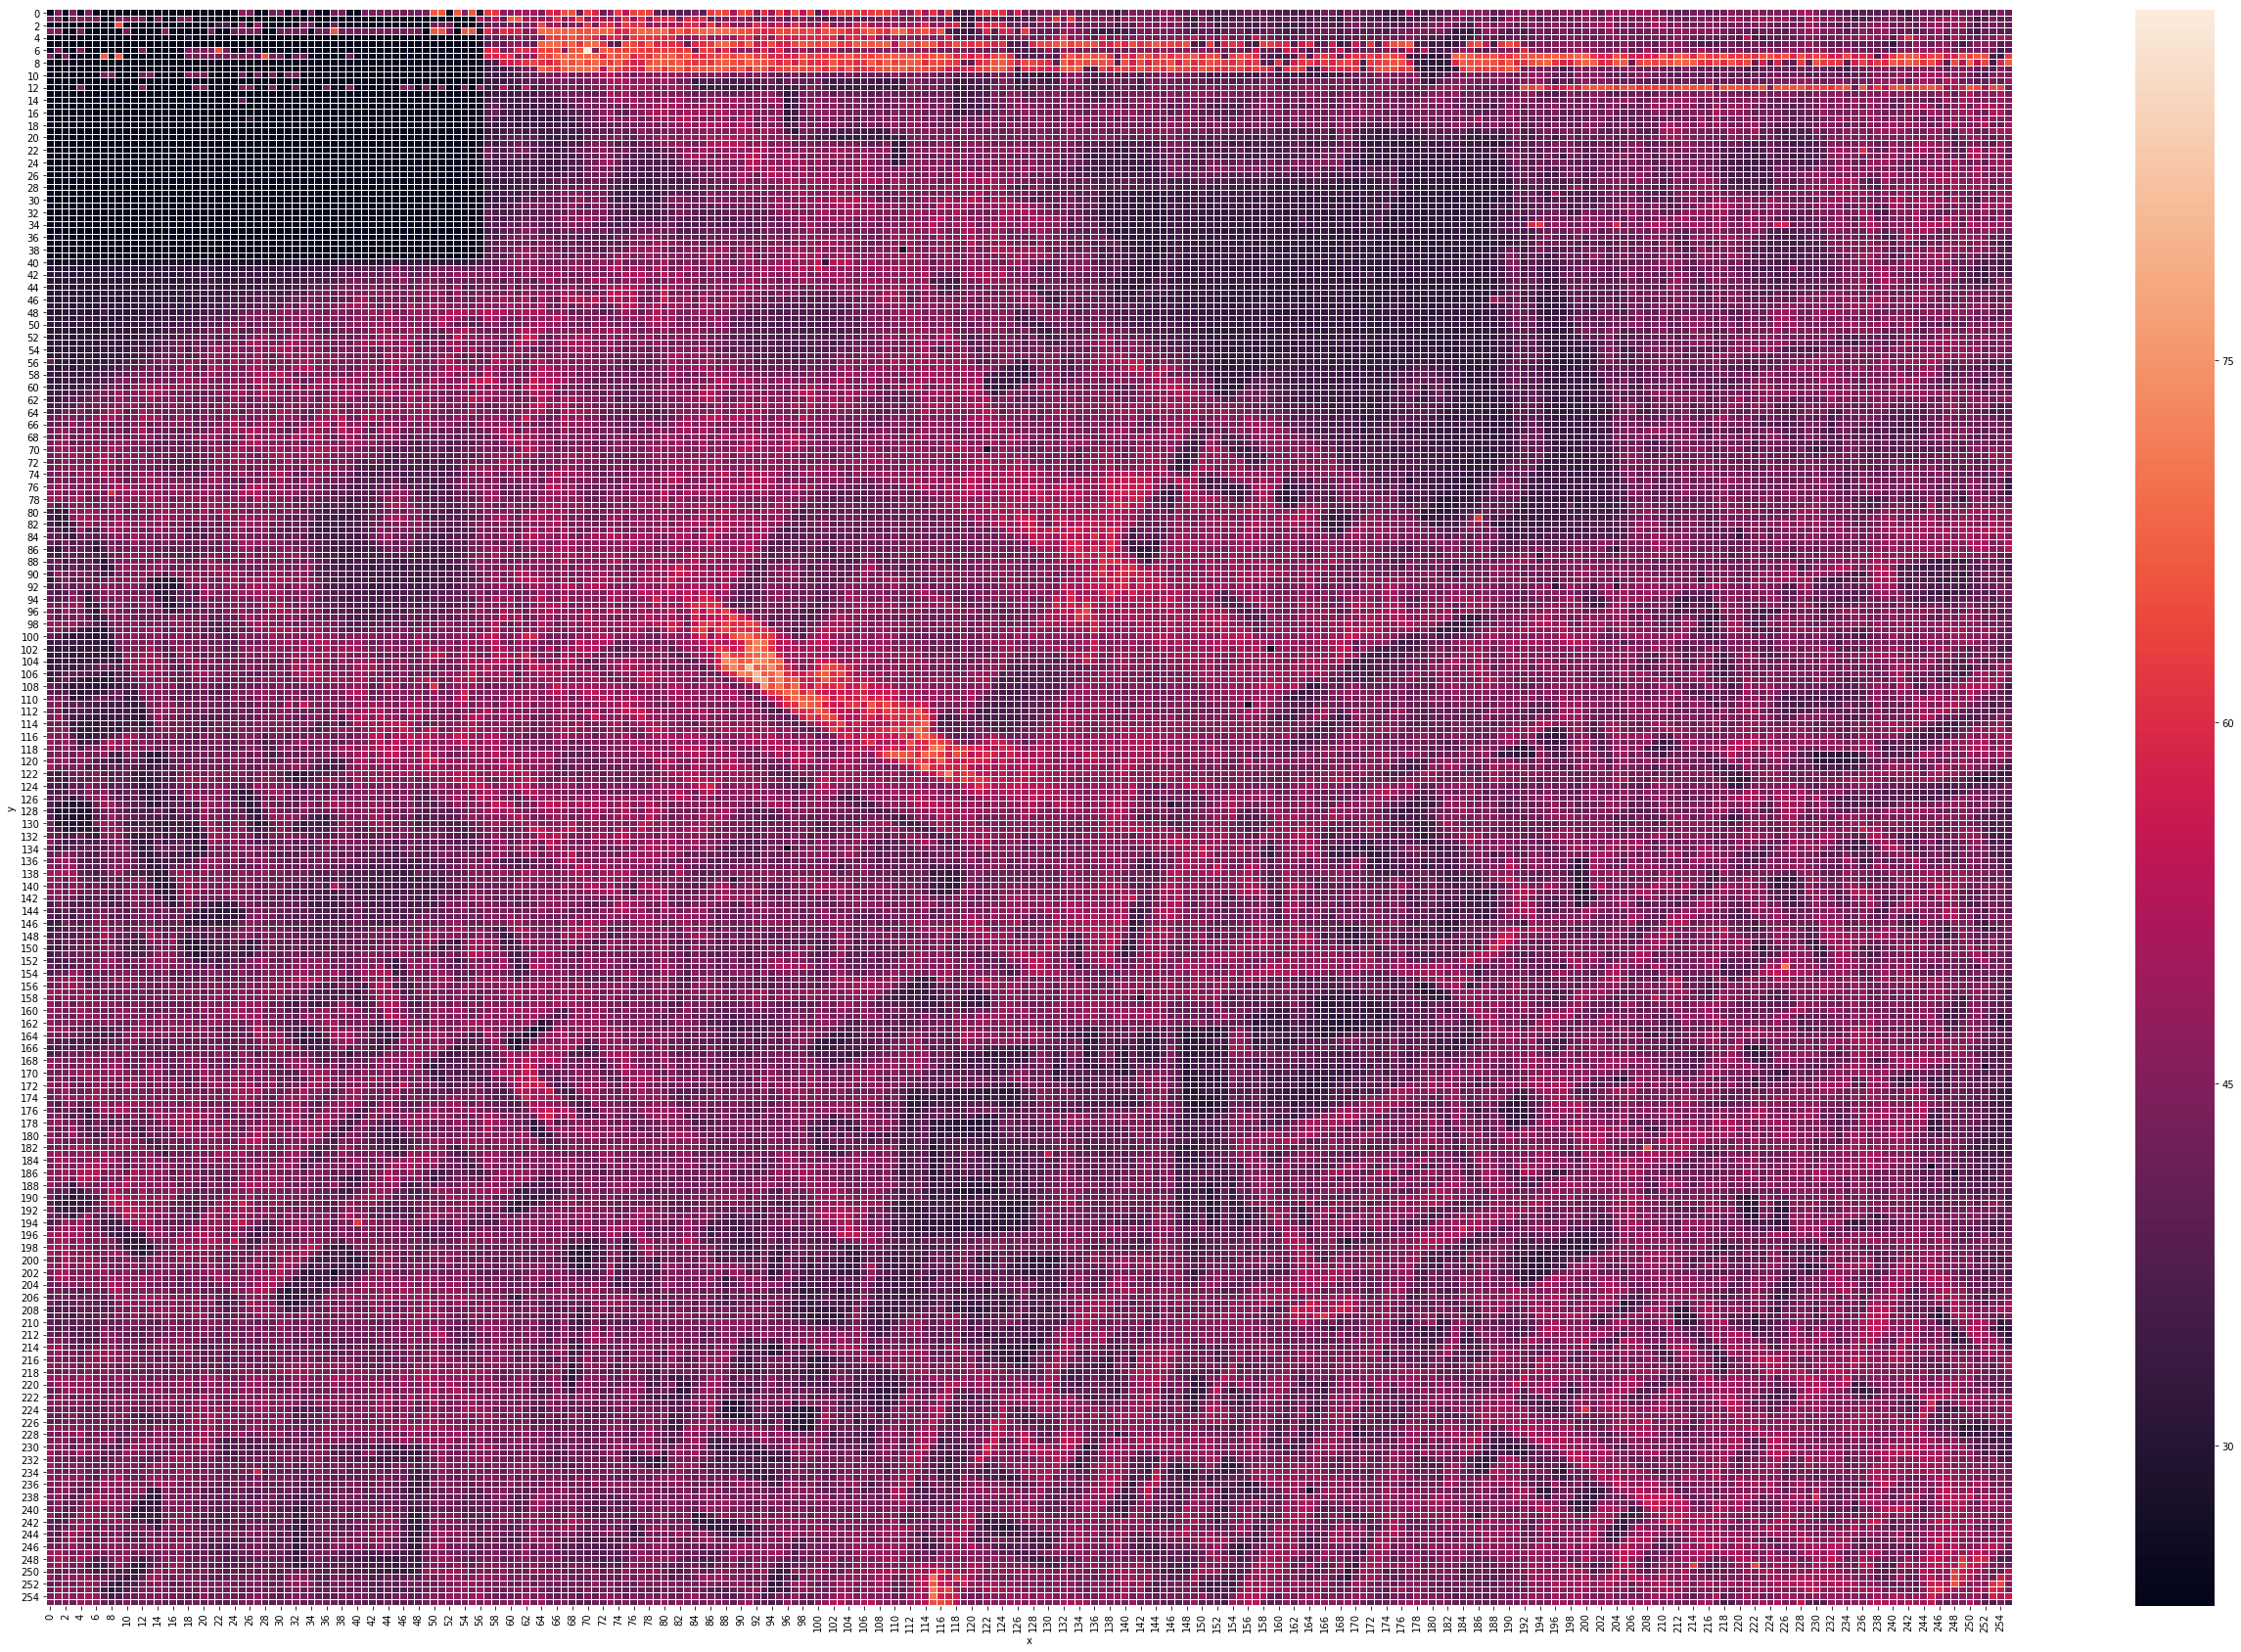

In [54]:
durations_l12 = df_duration_l12.pivot("y", "x", "duration")

f, ax = plt.subplots(figsize=(45, 30))
sns.heatmap(durations_l12,  linewidths=.01, ax=ax)

In [51]:
durations_l12

x,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
y,,,,,,,,,,,,,,,,,,,,,
0,24.627,45.483,24.393,44.146,24.672,44.434,24.569,25.016,24.534,24.695,...,40.070,41.677,48.411,40.974,41.372,41.030,40.494,36.308,44.604,41.289
1,43.248,43.856,24.953,43.869,44.417,44.033,44.324,25.308,24.587,44.076,...,47.508,50.389,47.444,47.015,42.935,35.685,39.072,45.256,39.465,42.594
2,24.413,24.418,24.711,24.218,24.924,24.215,23.958,24.297,24.355,66.302,...,49.508,43.772,47.568,48.952,41.247,35.865,41.846,43.505,41.811,39.271
3,44.470,44.776,24.264,24.504,44.239,24.989,24.879,24.326,24.377,24.739,...,49.189,43.073,44.921,43.252,37.131,35.202,40.643,40.090,38.626,38.170
4,24.060,24.515,24.504,24.541,24.111,24.547,24.579,24.656,24.741,24.339,...,46.229,39.354,52.257,44.330,40.591,39.997,44.388,43.866,52.311,47.335
5,24.394,24.627,24.320,24.282,24.899,23.924,24.215,24.167,23.934,24.553,...,46.985,48.342,41.318,35.970,40.090,46.631,47.400,45.892,38.671,41.582
6,24.637,44.728,24.182,24.094,44.612,23.505,24.400,24.272,25.091,23.752,...,48.528,47.667,42.189,44.702,42.760,43.165,43.342,41.486,35.357,36.827
7,43.896,24.295,44.327,24.493,24.435,24.948,24.821,67.008,24.443,66.941,...,63.925,57.298,58.951,66.057,62.485,66.383,64.941,35.311,34.591,62.130
8,24.471,24.257,24.826,24.507,24.528,24.232,24.256,24.338,24.655,24.863,...,57.845,37.963,64.773,52.898,67.358,53.347,63.712,36.023,59.429,67.107
